In [10]:
# for loading/processing the images  
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from PIL import Image

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd


# change the working directory to the path where the images are located

ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, 'dataset')
OUTPUT_PATH = os.path.join(ROOT_PATH, 'output')
PPDATA_PATH = os.path.join(ROOT_PATH, 'preprocessed')

if not os.path.exists(PPDATA_PATH):
    os.makedirs(PPDATA_PATH)


# utils

def converted_image(image):
    # load the image and save it in another dir
    img = Image.open(image)
    img = img.convert('RGB')
    ppimg_path = os.path.join(PPDATA_PATH,image.split('/')[-1].split('.')[-2]+'.jpg')
    img.save(ppimg_path)
    
    return ppimg_path
    

def extract_features(image, model):
    # convert from 'PIL.Image.Image' to numpy array
    img = load_img(image, target_size=(224,224))
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    
    return features

# function that lets you view a cluster (based on identifier)   
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

# model 

model = VGG16(weights='imagenet', input_shape=(224, 224, 3))
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [11]:
# this list holds all the image filename (it can take a long time)

images = []

for (dirpath, dirname, filename) in os.walk(DATA_PATH):
    for each_file in filename:
        # adds only the image files to the images' list
        images.append(converted_image(os.path.join(dirpath,each_file)))

In [12]:
data = {}

for image in images:
    feat = extract_features(image,model)
    data[image] = feat

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features and reshape to vectors of size 4096 

feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

1/1 [==============================] - 0s 17ms/step


In [13]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)


# cluster feature vectors

clustering = AgglomerativeClustering(n_clusters = None, linkage="single" ,metric="cosine", distance_threshold=0.20)
clustering.fit(x)

AgglomerativeClustering(distance_threshold=0.2, linkage='single',
                        metric='cosine', n_clusters=None)

In [14]:
# save these clusters in a dictionnary and in a directory

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

groups = {}
for file, cluster in zip(filenames,clustering.labels_):
    CLUSTER_PATH = os.path.join(OUTPUT_PATH,'cluster_'+ str(cluster))
    if not os.path.exists(CLUSTER_PATH):
        os.makedirs(CLUSTER_PATH)
    img = Image.open(file)
    img.save(os.path.join(CLUSTER_PATH,file.split('/')[-1].split('.')[-2]+'.jpg'))
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)


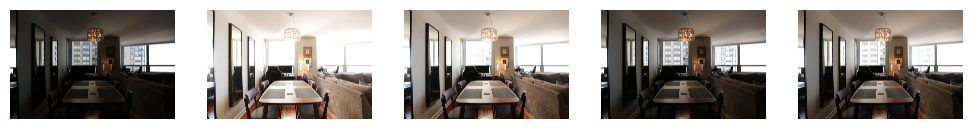

In [15]:
view_cluster(0)